# 0.0 Generalized Linear Models

The following are a set of methods intended for regression in which the target value is expected to be a linear combination of the input variables. In mathematical notion, if $\hat{y}$ is the predicted value.

$$
\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p
$$

Across the module, we designate the vector $w = (w_1, ... , w_p)$ as $\textit{coef_}$ and $w_0$ as $\textit{intercept_}$.

# 1.0 Ordinary Least Squares

LinearRegression fits a linear model with coefficients $w = (w_1, ... , w_p)$ to minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation. Mathematically it solves a problem of the form:

$$
\min_{w} \  ||Xw-y||_{2} ^2
$$

However, coefficient estimates for Ordinary Least Squares rely on the independence of the model terms. When terms are correlated and the columns of the design matrix $X$ have an approximate linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed response, producing a large variance. This situation of multicollinearity can arise, for example, when data are collected without an experimental design.

In [13]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import sklearn.linear_model as sklm
import scipy

kb = 1.38064e-23  # постоянная Больцмана
T = 273.15 + 22  # температура в K
theta = np.pi / 2  # угол рассеяния
n = 1.333  # показатель преломления
eta = 0.958e-3  # Н * с/м^2 - динамическая вязкость воды
l = 650e-9  # длина волны лазера

coeff = (kb * T / (3 * np.pi * eta)) * (4 * np.pi * n / l) ** 2 * np.sin(theta / 2) ** 2

In [14]:
# диапазон размеров частиц, где ищем нужный размер 
d_min = 1e-9 # 1 нм
d_max = 1e-6 

# задаем сетку по Gamma
G_min = coeff/d_max
G_max = coeff/d_min
N = 256*8 # число узлов в сетке по \Gamma

w = 2.0*np.arange(1,5001)
M = w.size # число точек по частоте
p = (G_max/G_min)**(1/(N-1))
G = np.zeros(N)

# неравномерная сетка со сгущением к нулю (так как больший вклад в интенсивность дают крупные частицы)
# хотя такая сетка - это не единственно возможный вариант
for j in range(N):
    G[j] = G_min * (p**j)

# вот равномерная сетка
#G = np.linspace(G_min, G_max, N)    

A = np.zeros((M,N))

# матрица коэффициентов (составляется по базисным ф-ям)
for i in range(M):
    for j in range(N):
        A[i,j] = G[j] / ((2 * np.pi * w[i])**2 + G[j]**2)  

In [15]:
# функция для построения для одного примера
import scipy.signal

def draw_given(w, d1, d2, i, y, y1 = [], y2 = []):
    fig = plt.figure()
    ax1 = plt.subplot(N_samples,2,2*i+1)
    
    if (len(y1) != 0): 
        plt.plot(w, y1, 'darkblue')
    if (len(y2) != 0): 
        plt.plot(w, y2, 'blue')
    
    plt.plot(w, y, 'red')
    # вывод уже умножив на 1e+9
    ax1.set_title('Peaks given: [{0:.0f}, {1:.0f}]'.format(d1 * 1e+9, d2 * 1e+9)) # {0:2.0e}
    ax1.set_xlabel('Frequency')
    
def draw_found(w, i, y):
    clf = sklm.LinearRegression()
    clf.fit(A, y)
    a = clf.coef_
    
    ax2 = plt.subplot(N_samples,2,2*i+2)
    line, = plt.plot(1e+9 * coeff/G, a,'.-')
    ax2.set_xscale('log')
    plt.xlim(d_min*1e9, d_max*1e9)
    ax2.set_xlabel('Diameter, *10e-9')
    
    height_start = 0.024 # height нужно задавать правильный
    height = height_start
    indexes, _ = scipy.signal.find_peaks(a, height, distance=50)
    while (len(indexes) != 2 and height > 0.75 * height_start):
        height -= height_start/50
        indexes, _ = scipy.signal.find_peaks(a, height, distance=50)
    peaks = sorted(1e+9*coeff/G[indexes])
    
    count_peaks = len(peaks)
    
    if (count_peaks == 0):
        ax2.set_title('Peaks not found')
    elif (count_peaks == 1):
        ax2.set_title('Peak found: [{0:.0f}]'.format(peaks[0]))
    elif (count_peaks == 2):
        ax2.set_title('Peaks found: [{0:.0f}, {1:.0f}]'.format(peaks[0], peaks[1])) # 'Peaks found: %s' % (1e+9*coeff/G[indexes])
    elif (count_peaks == 3):
        ax2.set_title('Peaks found: [{0:.0f}, {1:.0f}, {2:.0f}]'.format(peaks[0], peaks[1], peaks[2]))
    else:
        ax2.set_title('Too many peaks!')
        
    return (peaks[0:2], count_peaks)

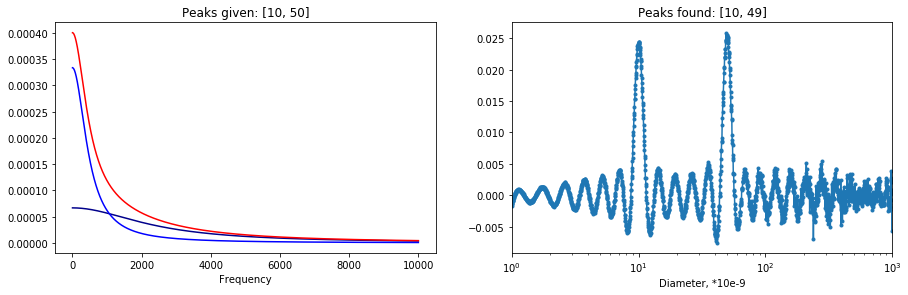

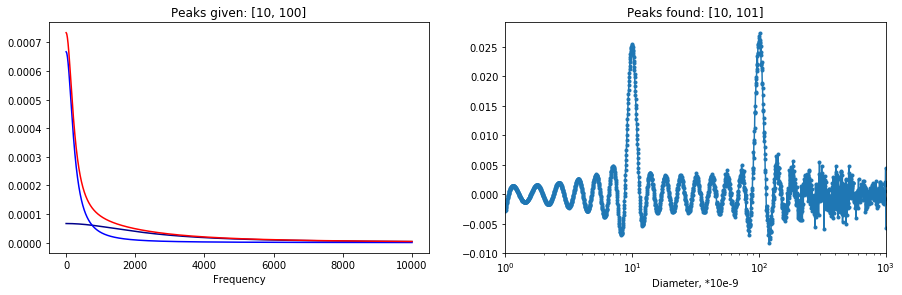

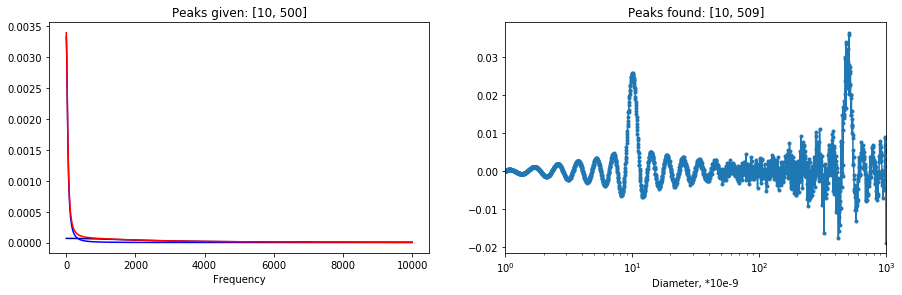

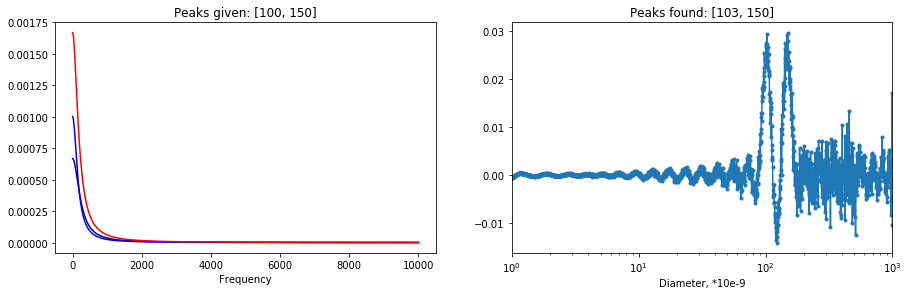

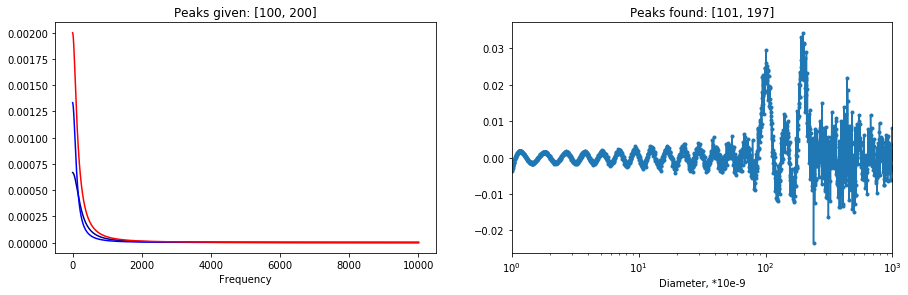

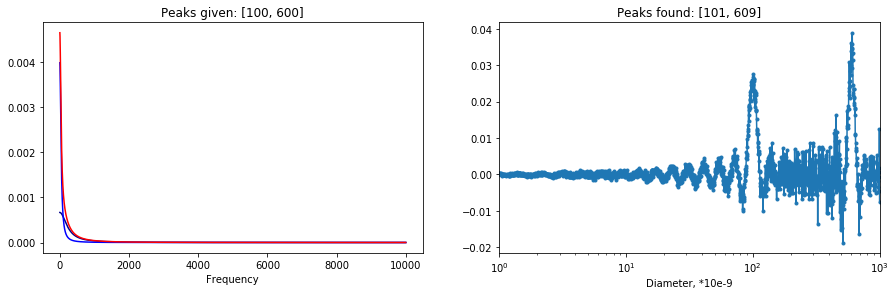

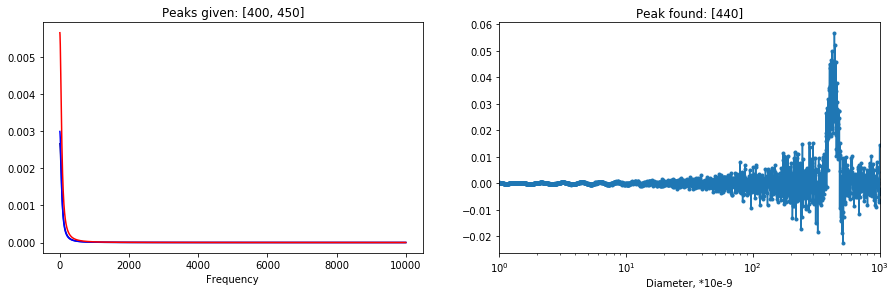

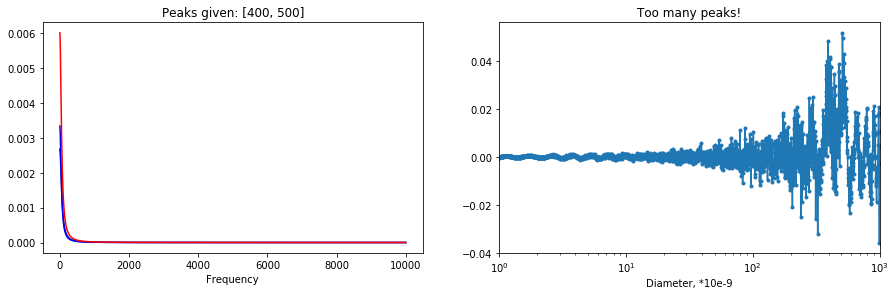

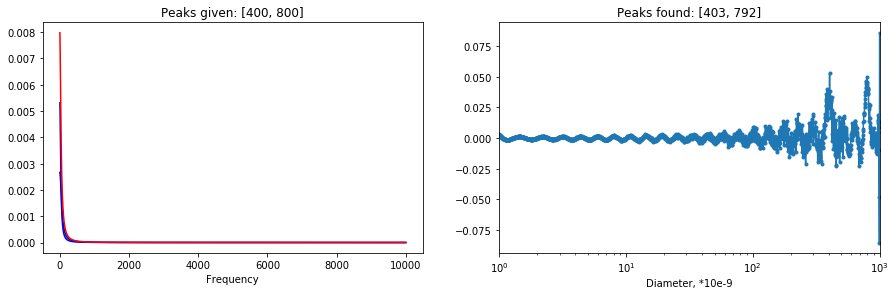

In [16]:
# set samples
N_samples = 9

# drawing improvements
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15 #width
fig_size[1] = 5 * N_samples #height
plt.rcParams["figure.figsize"] = fig_size

# samples
d1_mass = [10, 10, 10, 100, 100, 100, 400, 400, 400] 
# d1_mass = [10, 10, 50, 100, 100, 200, 400, 400] 
d1_mass = [sample * 1e-9 for sample in d1_mass]

d2_mass = [50, 100, 500, 150, 200, 600, 450, 500, 800]
# d2_mass = [50, 100, 500, 200, 400, 600, 500, 800]
d2_mass = [sample * 1e-9 for sample in d2_mass]

G1_mass = coeff / d1_mass
G2_mass = coeff / d2_mass

y_mass = np.zeros((N_samples, w.size))
peaks_found = np.zeros((N_samples, 2))
count_peaks = np.zeros(N_samples)
for i in range(N_samples):
    y1 = G1_mass[i] / ((2 * np.pi * w)**2 + G1_mass[i]**2)
    y2 = G2_mass[i] / ((2 * np.pi * w)**2 + G2_mass[i]**2)
    y_mass[i,:] = y1 + y2
    
    draw_given(w, d1_mass[i], d2_mass[i], i, y_mass[i,:], y1, y2)
    peaks_found[i,:], count_peaks[i] = draw_found(w, i, y_mass[i,:])

In [17]:
# error estimate
err = 0
bad_res = 0
good_res = N_samples

for j in range(N_samples):
    if (count_peaks[j] != 2):
        bad_res += 1
        good_res -= 1
        print('Cannot resolve the correct number of peaks with points: {0:.0f}, {1:.0f}'.format(d1_mass[j]*1e+9, d2_mass[j]*1e+9))
    else:
        err = max(err, np.abs(peaks_found[j,0] * 1e-9 - d1_mass[j])/d1_mass[j], np.abs(peaks_found[j,1] * 1e-9 - d2_mass[j]) / d2_mass[j])
print('\nNumber of bad results: {0}'.format(bad_res))
print('\nError: {0:.2f} - with good results: {1}'.format(err, good_res))

Cannot resolve the correct number of peaks with points: 400, 450
Cannot resolve the correct number of peaks with points: 400, 500

Number of bad results: 2

Error: 0.03 - with good results: 7


# Ordinary Least Squares method research results

Ordinary Least Squares method research shows that this method works bad with cloze-sized particles with difference less than 100-200 nm. Also there are some bad results with close-sized particles because of many output schedule asymptotes. In some cases, this method could find too many peaks instead of two. Moreover, the quality of recognition slightly decreases with increasing particle size. Finally, if the particles could be separated, their sizes are determined quite good with accuracy about 0.5-2.5 %.